Book recommender system
https://www.kaggle.com/datasets/mohamedbakhet/amazon-books-reviews/data?select=books_data.csv
Rating dataset has book and user ideas, helpfulness of review, number rating. Might use the helpfulness to weight how much the rating predicts other ratings.
Book dataset has categories for each book - some are missing, so could use description to predict the category (remove any missing descriptions and categories)
Add category to rating dataset - use as latent dimension in NMF (fiction readers, graphic novel readers, etc.)
Evaluate by reserving some ratings and checking accuracy

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import pairwise_distances
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.neighbors import NearestNeighbors
from scipy.sparse import csr_matrix

In [2]:
# Load data
ratings_df = pd.read_csv(r"C:\Users\mmull\OneDrive\Documents\MSDS\ML Unsupervised Project\Books_rating.csv\Books_rating.csv")
books_df = pd.read_csv(r"C:\Users\mmull\OneDrive\Documents\MSDS\ML Unsupervised Project\books_data.csv\books_data.csv")

In [3]:
# Found books associated with multiple bookIds
total_books = books_df['Title'].nunique()
total_bookids = ratings_df['Id'].nunique()
print('More bookids than books?', total_bookids > total_books)
print('Extra bookids: ', total_bookids - total_books)

# Drop duplicate titles
books_df = books_df.drop_duplicates('Title')

# Create bookids in book_info
book_info = books_df[['Title', 'authors', 'description', 'publisher', 'publishedDate', 'categories']]
# Drop observations with NAs
book_info = book_info.dropna()
# Add id
book_info.insert(0, 'bookId', book_info.index)
# Clean up feature names
book_info = book_info.rename(columns = {'Title': 'title', 'categories': 'category'})
# Standardize publication dates to year only
book_info.loc[:, 'publishedDate'] = book_info['publishedDate'].str[:4]


# Replace inaccurate Id column in ratings_df
ratings_df = ratings_df.merge(book_info[['bookId', 'title']], left_on = 'Title', right_on = 'title')

book_info.head()

More bookids than books? True
Extra bookids:  9595


,bookId,title,authors,description,publisher,publishedDate,category
1,1,Dr. Seuss: American Icon,['Philip Nel'],Philip Nel takes a fascinating look into the k...,A&C Black,2005,['Biography & Autobiography']
3,3,Whispers of the Wicked Saints,['Veronica Haddon'],Julia Thomas finds her life spinning out of co...,iUniverse,2005,['Fiction']
5,5,The Church of Christ: A Biblical Ecclesiology ...,['Everett Ferguson'],In The Church of Christ: A Biblical Ecclesiolo...,Wm. B. Eerdmans Publishing,1996,['Religion']
8,8,Saint Hyacinth of Poland,['Mary Fabyan Windeatt'],The story for children 10 and up of St. Hyacin...,Tan Books & Pub,2009,['Biography & Autobiography']
9,9,Rising Sons and Daughters: Life Among Japan's ...,['Steven Wardell'],Wardell recalls his experience as a foreign st...,Plympton PressIntl,1995,['Social Science']


In [4]:
ratings_df.head()

,Id,Title,Price,User_id,profileName,review/helpfulness,review/score,review/time,review/summary,review/text,bookId,title
0,0826414346,Dr. Seuss: American Icon,NaN,A30TK6U7DNS82R,Kevin Killian,10/10,5.0,1095724800,Really Enjoyed It,I don't care much for Dr. Seuss but after read...,1,Dr. Seuss: American Icon
1,0826414346,Dr. Seuss: American Icon,NaN,A3UH4UZ4RSVO82,John Granger,10/11,5.0,1078790400,Essential for every personal and Public Library,"If people become the books they read and if ""t...",1,Dr. Seuss: American Icon
2,0826414346,Dr. Seuss: American Icon,NaN,A2MVUWT453QH61,"Roy E. Perry ""amateur philosopher""",7/7,4.0,1090713600,Phlip Nel gives silly Seuss a serious treatment,"Theodore Seuss Geisel (1904-1991), aka &quot;D...",1,Dr. Seuss: American Icon
3,0826414346,Dr. Seuss: American Icon,NaN,A22X4XUPKF66MR,"D. H. Richards ""ninthwavestore""",3/3,4.0,1107993600,Good academic overview,Philip Nel - Dr. Seuss: American IconThis is b...,1,Dr. Seuss: American Icon
4,0826414346,Dr. Seuss: American Icon,NaN,A2F6NONFUDB6UK,Malvin,2/2,4.0,1127174400,One of America's greatest creative talents,"""Dr. Seuss: American Icon"" by Philip Nel is a ...",1,Dr. Seuss: American Icon


In [5]:
# dataset of user info - username, average helpfulness

ratings_df.drop('review/helpfulness', axis = 1, inplace = True)
user_df = pd.DataFrame({'User_id': ratings_df['User_id'].unique()})
# Drop observations with NAs
user_df = user_df.dropna()
user_df.head()

,User_id
0,A30TK6U7DNS82R
1,A3UH4UZ4RSVO82
2,A2MVUWT453QH61
3,A22X4XUPKF66MR
4,A2F6NONFUDB6UK


In [6]:
# rating dataset with bookid, userid, and rating
ratings_set = ratings_df[['Title', 'User_id', 'bookId', 'review/score']]
# clean up feature names
ratings_set = ratings_set.rename(columns = {'review/score': 'rating'})
# remove observations with NAs for User_id
ratings_set = ratings_set.dropna(axis = 0)
rated_books = ratings_set['Title'].unique().tolist()
# remove from book_info
book_info = book_info[book_info['title'].isin(rated_books)]

In [7]:
# Filter to highly reviewed books and users with many reviews
# books
top_reviewed = ratings_set.groupby('Title').count()['rating'] > 50
book_ids = top_reviewed[top_reviewed].index
filtered_ratings_set = ratings_set[ratings_set['Title'].isin(book_ids)]
# users
top_reviewers = filtered_ratings_set.groupby('User_id').count()['rating'] > 50
reviewer_ids = top_reviewers[top_reviewers].index
filtered_ratings_set = filtered_ratings_set[filtered_ratings_set['User_id'].isin(reviewer_ids)]
# reset index
filtered_ratings_set = filtered_ratings_set.reset_index(drop = True)
filtered_book_info = book_info[book_info['title'].isin(book_ids)]
filtered_user_df = user_df[user_df['User_id'].isin(reviewer_ids)]

filtered_ratings_set.head()

,Title,User_id,bookId,rating
0,Cruel and Unusual (G K Hall Large Print Book S...,A39650P2CZUUC9,106,4.0
1,Cruel and Unusual (G K Hall Large Print Book S...,AFVQZQ8PW0L,106,5.0
2,Cruel and Unusual (G K Hall Large Print Book S...,A2E9Q3T876TQ6C,106,4.0
3,Cruel and Unusual (G K Hall Large Print Book S...,A2GBJQ9THOYDAJ,106,4.0
4,Cruel and Unusual (G K Hall Large Print Book S...,ABWF7YVZAU1QP,106,4.0


In [8]:
n_ratings = len(filtered_ratings_set)
n_books = len(filtered_book_info['bookId'].unique())
n_users = len(filtered_user_df['User_id'].unique())
print("Total ratings: ", n_ratings)
print("Total unique books: ", n_books)
print("Mean number of ratings per book: ", round(n_ratings/n_books))
print("Total users: ", n_users)
print("Mean number of ratings per user: ", round(n_ratings/n_users, 2))
print("Mean rating across books and users: ", round(np.mean(ratings_set['rating']), 2))

Total ratings:  83346
Total unique books:  5008
Mean number of ratings per book:  17
Total users:  829
Mean number of ratings per user:  100.54
Mean rating across books and users:  4.22


Text(0.5, 1.0, 'Top 20 Categories (by Book Count)')

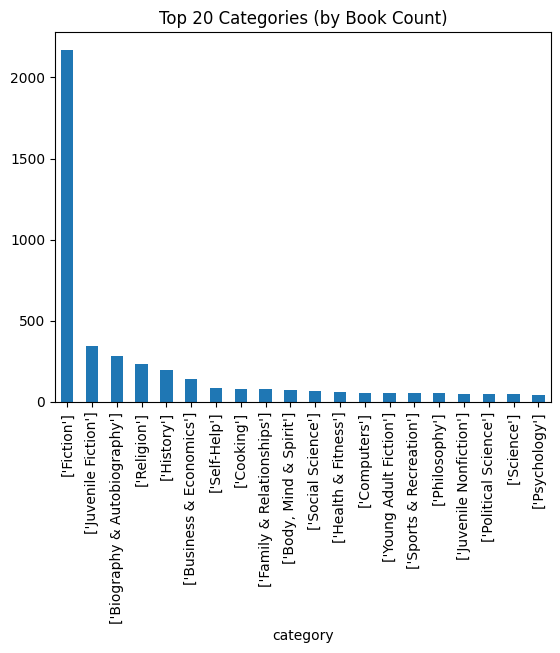

In [9]:
# Histogram of categories
category_counts_book = filtered_book_info['category'].value_counts()
top_by_book = category_counts_book[:20]
fig, ax = plt.subplots()
top_by_book.plot(ax = ax, kind = 'bar')
plt.title('Top 20 Categories (by Book Count)')

Text(0.5, 1.0, 'Most Reviewed Books')

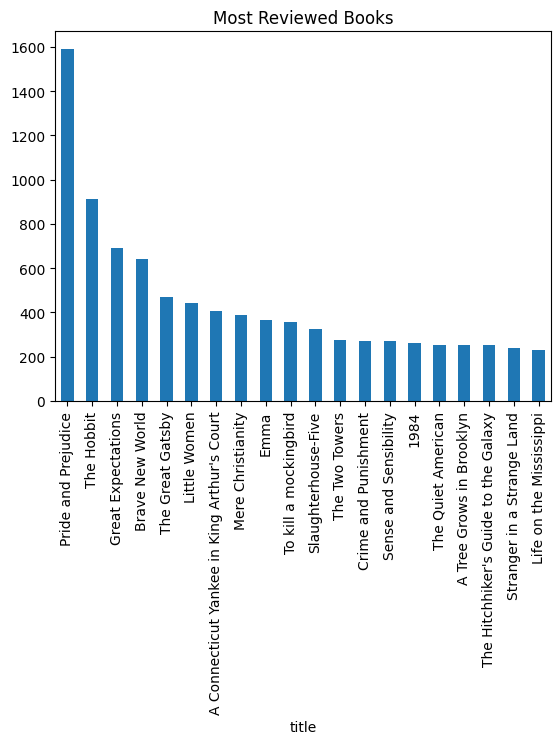

In [10]:
# Histogram of top 20 most reviewed books. All but one are fiction, which makes sense because fiction is the most frequent category
merged = filtered_book_info.merge(filtered_ratings_set, on = 'bookId')
top_books = merged['title'].value_counts()[:20]
fig, ax = plt.subplots()
top_books.plot(ax = ax, kind = 'bar')
plt.title('Most Reviewed Books')

Text(0.5, 1.0, 'Rating Histogram')

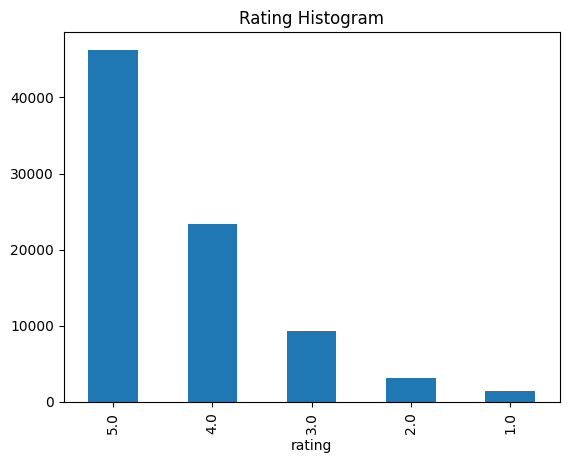

In [11]:
# Histogram of ratings. 5 stars is most frequent and 2 stars is least frequent
ratings = filtered_ratings_set['rating'].value_counts()
fig, ax = plt.subplots()
ratings.plot(ax = ax, kind = 'bar')
plt.title('Rating Histogram')

{'whiskers': [<matplotlib.lines.Line2D at 0x17092361940>,
 'caps': [<matplotlib.lines.Line2D at 0x1708e191880>,
 'boxes': [<matplotlib.lines.Line2D at 0x16fb4d584d0>],
 'medians': [<matplotlib.lines.Line2D at 0x1708e18ee40>],
 'fliers': [<matplotlib.lines.Line2D at 0x1708e18e090>],
 'means': []}

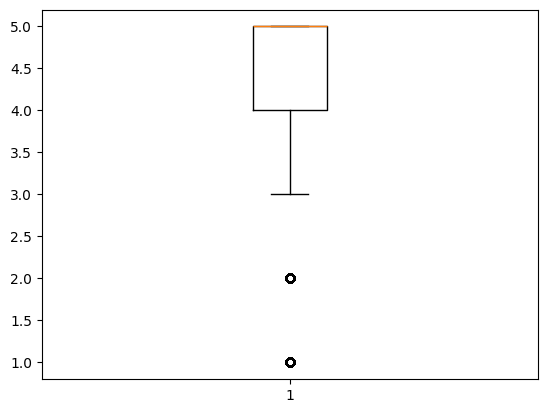

In [12]:
# The majority of ratings are between 3 and 5
plt.boxplot(filtered_ratings_set['rating'])

# Models

In [13]:
# split into train/test
train, test = train_test_split(filtered_ratings_set, test_size = 0.33, random_state = 42)
# train/test shape
print('Train shape:', train.shape, 'Test shape:', test.shape)
train.head()

Train shape: (55841, 4) Test shape: (27505, 4)


,Title,User_id,bookId,rating
18948,"Miracles, a preliminary study",A1IBC9XP2LICQL,43851,5.0
6210,Pompeii: A Novel,A2F1P10GGZ7K2T,13854,3.0
44236,The Life & Opinions of Tristram Shandy,A1SMUB9ASL5L9Y,110641,2.0
36125,Little House on the Prairie,A2I6MHMAZZDCRX,89301,5.0
19801,Alice's Adventures in Wonderland,AHEU0PXUZ4VA8,29230,4.0


# Cosine similarity

In [14]:
pivot_table = filtered_ratings_set.pivot_table(index = 'Title', columns = 'User_id',
                                              values = 'rating')
pivot_table.fillna(0, inplace = True)
pivot_table.head()

User_id,A106016KSI0YQ,A10T0OW97SFBB,A114YQ7ZT9Y1W5,A116J8AUC3JSN2,A11B61QBGHLQDN,A11DCTGTPS7M0C,A11M98R135HMSY,A11NL2A0RDEGF,A11ON2OFCF6RTV,A11PTCZ2FM2547,...,AXW1O6Q92XF0Z,AY46DEOJJYFTW,AY7B1ACIVSDTC,AYABUEJC2SEHQ,AYFNOHE3IQQ4G,AYPOMVBFYBVWE,AYT4FJYVCHYLE,AZ216MK9KO1S0,AZSNQ9FYC5SQO,AZSV99SDJC242
Title,,,,,,,,,,,,,,,,,,,,,
"""A"" IS FOR ALIBI",0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"""C"" is for Corpse (A Kinsey Millhone mystery, Book 3)",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"""D"" is for Deadbeat",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"""Hey, Whipple, Squeeze This"": A Guide to Creating Great Ads (Adweek Magazine Series)",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"1,000 Places to See Before You Die: A Traveler's Life List",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [15]:
# Standardize the ratings
scaler = StandardScaler(with_mean = True, with_std = True)
normed = scaler.fit_transform(pivot_table)

In [16]:
# Use cosine similarity for similarity matrix
book_sim = cosine_similarity(normed)

In [26]:
# Recommend similar books
def rec_sim_book(title):
    # Find index of target title
    index = np.where(pivot_table.index == title)[0][0]
    # Sort similarity scores and find 10 most similar books
    similar_books = sorted(list(enumerate(book_sim[index])), key = lambda x:x[1], reverse = True)[1:11]
    recs = []
    for index, similarity in similar_books:
        temp_df = filtered_ratings_set[filtered_ratings_set['Title'] == pivot_table.index[index]]
        recs.append(temp_df['Title'].unique()[0])
    print('If you liked', title, 'you might like:')
    for book in recs:
        print(book)

In [42]:
rec_sim_book(input())

 Pride and Prejudice


If you liked Pride and Prejudice you might like:
Pride & Prejudice (New Windmill)
Pride & Prejudice (Penguin Classics)
Pride and Prejudice
Emma
Emma (CH) (Jane Austen Collection)
Emma (Letras Universales / Universal Writings) (Spanish Edition)
Emma (Progress English)
Emma (Radio Collection)
Emma (Riverside Editions)
Emma (Signet classics)


In [20]:
# kNN
def user_item_matrix(df):
    # Indices for users
    N = len(df['User_id'].unique())
    M = len(df['bookId'].unique())
    # Map ID to indices
    user_map = dict(zip(np.unique(df['User_id']), list(range(N))))
    book_map = dict(zip(np.unique(df['bookId']), list(range(M))))
    # Map indices to ID
    inverse_user_map = dict(zip(list(range(N)), np.unique(df['User_id'])))
    inverse_book_map = dict(zip(list(range(M)), np.unique(df['bookId'])))
    # Generate indices for each observation in ratings_set
    user_index = [user_map[i] for i in df['User_id']]
    book_index = [book_map[i] for i in df['bookId']]
    V = csr_matrix((df['rating'], (book_index, user_index)), shape = (M, N))
    return V, user_map, book_map, inverse_user_map, inverse_book_map

In [21]:
# Find nearest neighbors
def knn_rec(book, matrix, k, metric = 'cosine', show_distance = False):
    neighbors = []
    book_index = book_map[book]
    book_vector = matrix[book_index]
    k += 1
    kNN = NearestNeighbors(n_neighbors = k, algorithm = 'brute', metric = metric)
    kNN.fit(matrix)
    book_vector.reshape(1, -1)
    neighbor = kNN.kneighbors(book_vector, return_distance = show_distance)
    for i in range(k):
        n = neighbor.item(i)
        neighbors.append(inverse_book_map[n])
    neighbors.pop(0)
    return neighbors

In [22]:
V, user_map, book_map, inverse_user_map, inverse_book_map = user_item_matrix(filtered_ratings_set)

In [37]:
# Sample result
book_titles = dict(zip(filtered_book_info['bookId'], filtered_book_info['title']))
input_title = input()
input_id = list(book_titles.keys())[list(book_titles.values()).index(input_title)]
similar_ids = knn_rec(input_id, V, k = 10)
print('If you liked', input_title, 'you might like:')
for i in similar_ids:
    print(book_titles[i])

 ttyl


If you liked ttyl you might like:
The Scrambled States of America
Keeping You a Secret
forever
Z for Zachariah
Under the Overpass: A Journey of Faith on the Streets of America
Megan Meade's Guide to the McGowan Boys
Flyte (Septimus Heap, Book 2)
The River
13 Little Blue Envelopes
The A-List: A Novel
